# Diffusion Model

In [1]:
# Import the necessary modules
import math
from functools import partial
from typing import Optional

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm


device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

In [2]:
# Main experimental settings
timesteps = 200
epochs = 5

# Loading the dataset


In [3]:
base_dir = "../data"


config = {
    "data_path": f"{base_dir}/processed",
    "sst_path": f"{base_dir}/SST",
    "periods": {
        "train": slice("1998-01-01", "2013-12-31"),
        "test": slice("2016-01-01", "2021-12-31"),
        "val": slice("2014-01-01", "2015-12-31"),
    },
    "time_window": 5,
    "num_epochs": 100,
    "bs": 32,
    "lr": 1e-4,
    "device": device,
}


In [ ]:
import xarray as xr

chl = xr.open_mfdataset(f"{config["sst_path"]}/*.nc", engine="h5netcdf")
# chl = (chl - chl.mean(dim="time")) / chl.std(dim="time")
chl = chl.isel(latitude=range(64), longitude=range(64))
chl = (chl - chl.min(dim="time")) / (chl.max(dim="time") - chl.min(dim="time"))
chl

In [ ]:
import numpy as np

valid_counts = chl["Chl"].notnull().sum(dim=["lat", "lon"])
threshold = np.ceil(0.5 * 64 * 64)
valid_counts = valid_counts.compute()
days_to_keep = valid_counts.where(valid_counts > threshold, drop=True).time
days_to_keep

In [ ]:
data = chl.sel(time=days_to_keep)
data

In [13]:
class Dataset2d(Dataset):
    def __init__(self, dataset, time_window=8, mode="zero", transform=None):
        self.target = torch.tensor(dataset["analysed_sst"].values)

        self.target_time = time_window // 2
        self.missing_mask = torch.isnan(self.target)  # 1 if missing, 0 if present
        self.time_window = time_window

        self.transform = transform

        self.fill_missing(mode)

    def __len__(self):
        return len(self.target) - self.time_window + 1

    def __getitem__(self, idx):
        timerange = range(idx, idx + self.time_window)
        target_timerange = timerange[self.target_time]

        return (
            target_timerange,
            self.target[target_timerange],
            self.missing_mask[target_timerange],
        )

    def fill_missing(self, mode):
        if mode == "constant":
            self.target[self.missing_mask] = 99999.0
        elif mode == "zero":
            self.target[self.missing_mask] = 0.0
        else:
            raise ValueError(f"Unknown mode: {mode}")

In [24]:
train_dataset = Dataset2d(chl, time_window=1, mode="zero")

In [28]:
train_loader = DataLoader(
    train_dataset,
    batch_size=config["bs"],
    shuffle=True,
)

# Displaying images



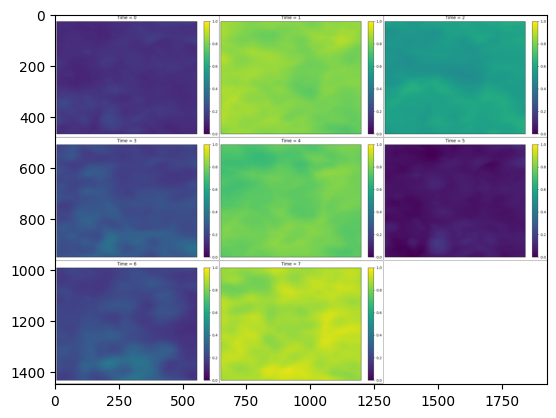

In [30]:
from src.utils.helpers import create_grid_from_2d_batch

times = next(iter(train_loader))[0][:8]
imgs = next(iter(train_loader))[1][:8]

grid = create_grid_from_2d_batch(imgs, cmap="viridis", vrange=(0, 1))

# Diffusion Process

Let $q(\mathbf{x}_0)$ be the real data distribution, say of "real images". We
can sample from this distribution to get an image, $\mathbf{x}_0 \sim
q(\mathbf{x}_0)$. We define the forward diffusion process $q(\mathbf{x}_t |
\mathbf{x}_{t-1})$ which adds Gaussian noise at each time step $t$, according
to a known variance schedule $0 < \beta_1 < \beta_2 < ... < \beta_T < 1$ as

$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 -
\beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}).
$$

Said otherwise, $$ \mathbf{x}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +
\sqrt{\beta_t} \epsilon $$ with $\epsilon \sim \mathcal N(0, \mathbf{I})$.

# Schedules

There were many propositions to set the $\beta_t$ - whose general name is
_schedule_. Some are defined below:

- `LinearSchedule`
- `QuadraticSchedule`
- `SigmoidSchedule`


In [31]:
class Schedule:
    def __init__(self, betas):
        # Store basic information
        self.timesteps = len(betas)
        self.betas = betas
        self.alphas = 1.0 - betas

        # Pre-compute useful values:
        # use them in your code!
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

        self.alphas_cumprod_prev = nn.functional.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.0
        )

        self.posterior_variance = (
            betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )


class LinearSchedule(Schedule):
    def __init__(self, timesteps):
        beta_start = 0.0001
        beta_end = 0.02
        super().__init__(torch.linspace(beta_start, beta_end, timesteps))


class QuadraticSchedule(Schedule):
    def __init__(self, timesteps):
        beta_start = 0.0001
        beta_end = 0.02
        super().__init__(torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2)


class SigmoidSchedule(Schedule):
    def __init__(self, timesteps):
        beta_start = 0.0001
        beta_end = 0.02
        betas = torch.linspace(-6, 6, timesteps)
        super().__init__(torch.sigmoid(betas) * (beta_end - beta_start) + beta_start)

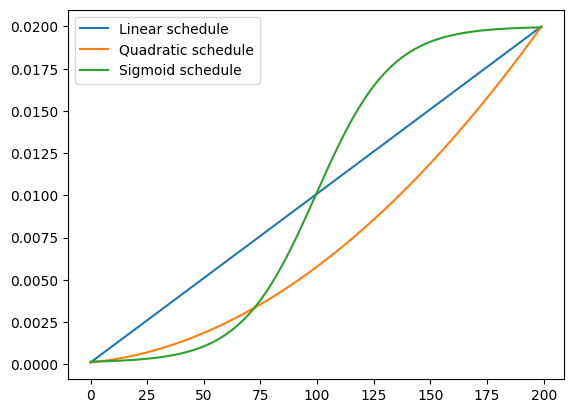

In [32]:
# Display the schedules
timesteps = 200

plt.plot(LinearSchedule(timesteps).betas, label="Linear schedule")
plt.plot(QuadraticSchedule(timesteps).betas, label="Quadratic schedule")
plt.plot(SigmoidSchedule(timesteps).betas, label="Sigmoid schedule")
plt.legend()
plt.show()

In many places, we need to take time specific values (from the schedule $\beta_t$)
or one of the derived values. The function `temporal_gather` can be used
for such manipulations:


In [33]:
def temporal_gather(a: torch.Tensor, t: torch.LongTensor, x_shape):
    """Gather values from tensor `a` using indices from `t`.

    Adds dimensions at the end of the tensor to match with the number of dimensions
    of `x_shape`
    """
    batch_size = len(t)
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [34]:
# Example of use

temporal_gather(
    # The tensor from which we gather values
    torch.Tensor([1.1, 1.2, 1.3, 1.4]),
    # The Tensor giving
    torch.LongTensor([0, 1, 1, 0, 2]),
    # Just a shape...
    torch.zeros(1, 5, 3).shape,
)

tensor([[[1.1000]],

        [[1.2000]],

        [[1.2000]],

        [[1.1000]],

        [[1.3000]]])

# Sampling $q(x_t|x_0)$

A direct consequence of the constructed forward process $q$, as shown by [(Sohl-Dickstein et al., 2015)](https://arxiv.org/abs/1503.03585), is that we can sample $\mathbf{x}_t$ at any arbitrary noise level conditioned on $\mathbf{x}_0$ (since a sum of Gaussians is also Gaussian). This is very convenient: we don't need to apply $q$ repeatedly in order to sample $\mathbf{x}_t$.
We have that
$$q(\mathbf{x}_t | \mathbf{x}_0) = \cal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1- \bar{\alpha}_t) \mathbf{I})$$
with $$\alpha_t = 1 - \beta_t\ \textrm{ and }\ \bar{\alpha}_t = \Pi_{s=1}^{t} \alpha_s$$

Let's refer to this equation as the "nice property". This means we can sample Gaussian noise and scale it appropriately and add it to $\mathbf{x}_0$ to get $\mathbf{x}_t$ directly. Note that the $\bar{\alpha}_t$ are functions of the known $\beta_t$ variance schedule and thus are also known and can be precomputed. This then allows us, during training, to **optimize random terms of the loss function $L$** (or in other words, to randomly sample $t$ during training and optimize $L$.


In [35]:
def q_sample(
    schedule: Schedule,
    x_0: torch.Tensor,
    t: torch.LongTensor,
    noise: Optional[torch.Tensor] = None,
):
    """Sample q(x_t|x_0) for a batch

    Args:
        schedule (Schedule): The $\beta_t$ schedule

        x_0 (torch.Tensor): A batch of images (N, C, W, H)

        t (torch.Tensor): A 1D tensor of integers (time)

        noise (torch.Tensor, optional): Sampled noise of the same dimension than
        x_0; if not given, sample one. Defaults to None.
    """
    if noise is None:
        noise = torch.randn_like(x_0)
    shape = x_0.size()
    sqrt_alphas_cumprod = temporal_gather(schedule.sqrt_alphas_cumprod, t, shape)
    sqrt_one_minus_alphas_cumprod = temporal_gather(
        schedule.sqrt_one_minus_alphas_cumprod, t, shape
    )
    return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * noise


# Check that everything is all right
x_0 = torch.Tensor([[2.3, 1.2, 4.2], [5.4, 3.2, 1.4]])
noise = torch.Tensor(
    [
        [0.4938392937, 0.5089217424, 1.4516087770],
        [-1.1347782612, -1.3416436911, -0.1392416954],
    ]
)
expected = torch.Tensor(
    [
        [2.3507647514, 1.2699846029, 4.3878836632],
        [5.3043818474, 3.0952007771, 1.3863569498],
    ]
)
t = torch.LongTensor([3, 1])
observed = q_sample(LinearSchedule(5), x_0, t, noise=noise)
assert torch.allclose(observed, expected)

We can now show various samples with various $t$


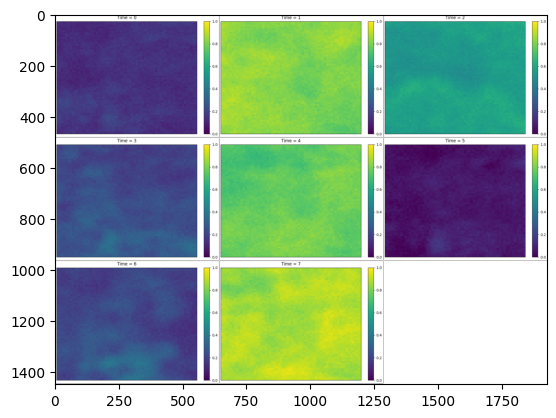

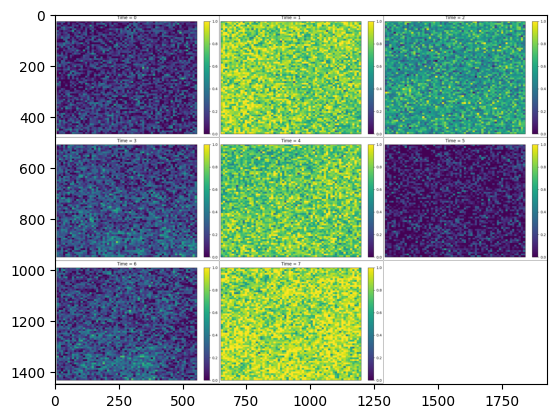

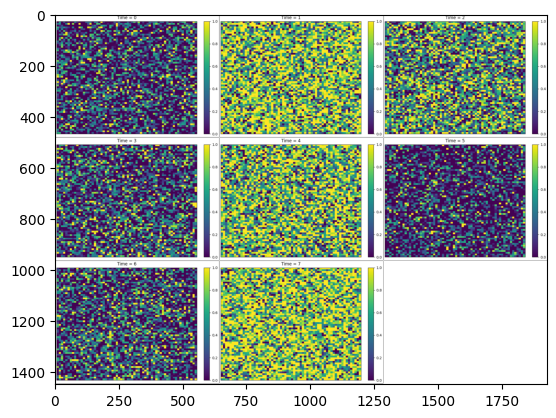

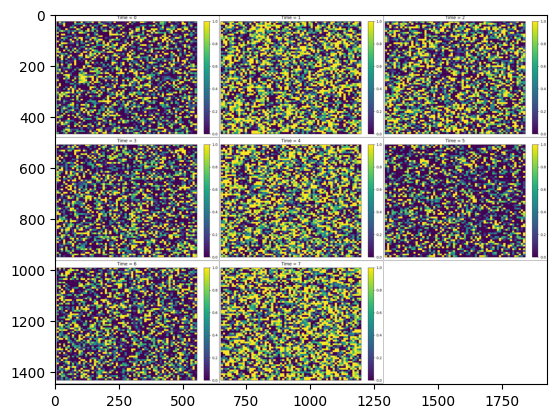

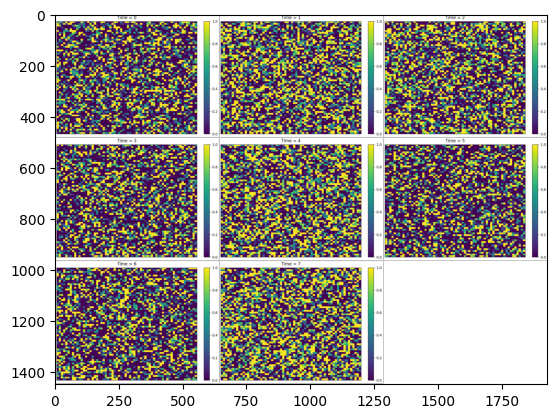

In [37]:
schedule = SigmoidSchedule(timesteps)

images = []
for t in [0, timesteps // 4, 2 * (timesteps // 4), 3 * (timesteps // 4), timesteps - 1]:
    x_t = q_sample(schedule, imgs, torch.LongTensor([t]))
    plt.imshow(
        create_grid_from_2d_batch(x_t, cmap="viridis", vrange=(0, 1))
    )
    plt.show()

# Training

Now that we can generate samples at various time steps, we now turn to
training diffusion models, that is, we want to learn the parametric
distributions $$p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) =
\mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t),
\boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))$$

$$
\begin{aligned}
NLL = - \log p_\theta(\mathbf{x}_0)
&\leq - \log p_\theta(\mathbf{x}_0) + D_\text{KL}(q(\mathbf{x}_{1:T}\vert\mathbf{x}_0) \| p_\theta(\mathbf{x}_{1:T}\vert\mathbf{x}_0) ) \\
&= \mathbb{E}_q \Big[ \log \frac{q(\mathbf{x}_{1:T}\vert\mathbf{x}_0)}{p_\theta(\mathbf{x}_{0:T})} \Big] =  L_{\mathrm{VLB}} \\
\end{aligned}
$$

It can be shown that

$$
L_{\mathrm{VLB}} = \mathbb{E}_q [\underbrace{D_\text{KL}(q(\mathbf{x}_T \vert \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T))}_{L_T} + \sum_{t=2}^T \underbrace{D_\text{KL}(q(\mathbf{x}_{t-1} \vert \mathbf{x}_t, \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_{t-1} \vert\mathbf{x}_t))}_{L_{t-1}} \underbrace{- \log p_\theta(\mathbf{x}_0 \vert \mathbf{x}_1)}_{L_0} ]
$$

where $L$ is constant (since $x_T$ is by hypothesis Gaussian noise) wrt parameters ($q$ has no parameters). The term $L_{t-1}$ is a KL divergence between two Gaussians and can be computed in _closed form_.

## Reparametrization trick

As shown in [(Ho et al., 2021)](https://arxiv.org/abs/2106.15282) is that one
can instead reparametrize the mean to make the neural network learn (predict)
the added noise via a network $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$ for
noise level $t$.

Said otherwise,

$$
\mathbf{x}_{t-1} \vert \mathbf{x}_t \sim \mathcal{N}\left( \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \Big), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t)\right)
$$

The final objective function $L$ - with some extra simplifications
as shown in [(Ho et al., 2021)](https://arxiv.org/abs/2106.15282),
is simply:

$$
L = \mathbb{E}_{x_0 \sim q, t \sim \mathcal U(\{1,\ldots, T\})} \|
\mathbf{\epsilon} - \mathbf{\epsilon}_\theta( \sqrt{\bar{\alpha}_t}
\mathbf{x}_0 + \sqrt{(1- \bar{\alpha}_t)  } \mathbf{\epsilon}, t) \|^2
$$


 $$
        \tilde{\boldsymbol{\mu}}_t = \frac{1}{\sqrt{\alpha_t}} \Big( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big)

    $$

# Defining the noise model

We are now interested in defining the function $\epsilon_\theta(\mathbf{x}, t)$.
To represent time, we use positional embeddings similar to those
used to define transformers.
The code is the cell below defines a `SinusoidalPositionEmbeddings`
module that computes the embeddings of a vector of time


In [38]:
class SinusoidalPositionEmbeddings(nn.Module):
    """Positional embeddings"""

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time: torch.Tensor):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


# Example of use
t_emb = SinusoidalPositionEmbeddings(10)
t_emb(torch.LongTensor([5, 3, 2])).shape

torch.Size([3, 10])

# Image Generation: U-Net

The consensus is to use an architecture derived from U-Net, a model used
for image segmentation. The code in the next block correspond
to this model. You do not need to read the code itself (unless
you really want to).

The U-Net model has been modified in order to take as
input a time embeddings that modifies its output.


In [39]:
# Define the UNet architecture

from einops import rearrange
from torch import einsum


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


def defined(x):
    return x is not None


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, kernel_size=4, stride=2, padding=1)


def Downsample(dim):
    return nn.Conv2d(dim, dim, kernel_size=4, stride=2, padding=1)


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if defined(scale_shift):
            assert False, "I thought you would not come here"
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if time_emb_dim
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x: torch.Tensor, time_emb=None):
        h = self.block1(x)

        if defined(self.mlp) and defined(time_emb):
            time_emb = self.mlp(time_emb)
            # h = rearrange(time_emb, "b c -> b c 1 1") + h
            h = time_emb.unsqueeze(-1).unsqueeze(-1) + h

        h = self.block2(h)
        return h + self.res_conv(x)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


class Unet(nn.Module):
    def __init__(
        self,
        dim,
        *,
        init_dim=None,
        out_dim=None,
        dim_mults=(
            1,
            2,
            4,
        ),
        channels=3,
        time_dim=None,
        resnet_block_groups=4,
    ):
        """Unet architecture

        Args:
            dim (int): The dimension of the image (assumes a square image)
            init_dim (int, optional): The initialisation. Defaults to `dim // 3 * 2`.
            out_dim (int, optional): The output dimension. Defaults to channels.
            dim_mults (tuple, optional): List of ints. Defaults to (1, 2, 4).
            channels (int, optional): The number of input channels. Defaults to 3.
            time_dim (bool, optional): Time embeddings dimension. Defaults to None.
            resnet_block_groups (int, optional): Number of groups for ResNet layer normalization. Defaults to 8.
        """
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.time_dim = time_dim

        # First convolution
        init_dim = init_dim or (dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *(dim * m for m in dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        resnet_block = partial(ResnetBlock, groups=resnet_block_groups)

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        resnet_block(dim_in, dim_out, time_emb_dim=time_dim),
                        resnet_block(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        resnet_block(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        resnet_block(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = out_dim or channels
        self.final_conv = nn.Sequential(
            resnet_block(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, t: Optional[torch.Tensor] = None):
        assert defined(t) or not defined(self.time_dim), "No time embeddings given"

        x = self.init_conv(x)
        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

# Defining the model

In the code below, you need to define the
noise model $\epsilon_\theta$. Don't forget
to take into account the time embeddings
using one of the PositionEmbeddings classes.


In [40]:
class Model(nn.Module):
    def __init__(self, dim, out_dim=1, channels=1):
        """Initialize our noise model

        Args:
            dim (int): The width/height of an image
            channels (int, optional): The number of channels of the image. Defaults to 1.
        """
        super().__init__()
        self.image_size = dim
        self.channels = channels
        self.out_dim = out_dim
        self.t_emb = SinusoidalPositionEmbeddings(dim * 4)
        self.unet = Unet(dim, channels=channels, out_dim=out_dim, time_dim=dim * 4)

    def forward(self, x_t, time):
        return self.unet(x_t, self.t_emb(time))

# Sampling

Before writing the training loop, we first set up the sampling
function - that is, the procedure that generates an image
from Gaussion noise.

You will need to complete the functions `sample` and `p_sample`.
Note that we work with batches and that `sample` returns
the images for all time steps $x_{T-1}, \ldots, x_{0}$.

The function `sample` handles the main decoding loop:

- Sample $X_T \sim \mathcal N(\mathbf 0, \mathbf I)$
- For $t=T,\ldots,1$ compute $x_{t-1} = \mathrm{p\_sample}(x_{t}, t)$
- Return $x_0$

where the function `p_sample`, that you will code, is defined by:

1. If $t>1$, sample $\mathbf z \sim \mathcal N(\mathbf 0, \mathbf I)$, else $z = \mathbf 0$
1. $x_{t-1} = \frac 1 {\sqrt{\alpha_t}} \left( \mathbf x_t - \frac{1-\alpha_t}{\sqrt{1-\bar\alpha_t}} \mathbf{\epsilon}_\theta(\mathbf{x}_t, t)  \right) + \sigma_t \mathbf z$ with $$\sigma_t = \beta_t \times \frac{1-\bar\alpha_{t-1}}{1-\alpha_1-\alpha_t}$$


In [ ]:
@torch.no_grad()
def p_sample(schedule: Schedule, model: Model, x: torch.Tensor, t_index: int):
    shape = x.size()
    device = x.device

    # Step 1: Sample z
    z = (
        torch.randn(shape, device=device)
        if t_index > 1
        else torch.zeros(shape, device=device)
    )

    # Step 2: Compute x_{t-1}
    noise_pred = model(x, torch.LongTensor([t_index]).to(device))
    x_prev = schedule.sqrt_recip_alphas[t_index] * (
        x
        - (1.0 - schedule.alphas[t_index])
        / schedule.sqrt_one_minus_alphas_cumprod[t_index]
        * noise_pred
    )
    x_prev = x_prev + schedule.posterior_variance[t_index] * z

    return x_prev


@torch.no_grad()
def sample(schedule, model, batch_size=16):
    """Sample images from the generation model

    Args:
        schedule (Schedule): The variance schedule
        model (Model): The noise model
        batch_size (int, optional): Number of images to generate. Defaults to 16.

    Returns:
        List[torch.Tensor]: List of images for each time step $x_{T-1}, \ldots, x_0$
    """
    image_size = model.image_size
    channels = model.channels
    device = next(model.parameters()).device

    # Will contain $x_{T-1}, \ldots, x_0$
    imgs = []

    # Sample x_T from a standard normal distribution
    x_t = torch.randn(batch_size, channels, image_size, image_size, device=device)

    # Sampling loop
    for t_index in range(schedule.timesteps - 1, -1, -1):
        x_t = p_sample(schedule, model, x_t, t_index)
        imgs.append(x_t.cpu())
    return imgs


# Training loop

We are now ready to code the training loop. Note that
instead of using a L2 loss, you can use a Smooth L1
one - which is less sensitive to outliers.

We recall that the final objective function $L$ is:

$$
L = \mathbb{E}_{x_0 \sim q, t \sim \mathcal U(\{1,\ldots, T\})} \|
\mathbf{\epsilon} - \mathbf{\epsilon}_\theta( \sqrt{\bar{\alpha}_t}
\mathbf{x}_0 + \sqrt{(1- \bar{\alpha}_t)  } \mathbf{\epsilon}, t) \|^2
$$


In [77]:
from src.models.loss import mse_loss

model = Model(dim=64, channels=1).to(device)
criterion = mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
schedule = SigmoidSchedule(timesteps)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

8157045

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


writer = SummaryWriter(
    log_dir=f"runs/Diffusion/SST_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
)


epochs = 10  # config["num_epochs"]

total_batches = epochs * len(train_loader)
with tqdm(total=total_batches, desc=f"Epoch 1/{epochs}", unit="batch") as pbar:
    for epoch in range(epochs):
        for step, (time, target, mask) in enumerate(train_loader):
            optimizer.zero_grad()

            batch_size = target.shape[0]
            # inputs = inputs.to(device).float()  # B, T, H, W
            target = target.to(device).float().unsqueeze(1)  # B, 1, H, W
            mask = mask.to(device).float().unsqueeze(1)  # B, 1, H, W

            # Sample random timesteps
            noise = torch.randn_like(target, device=device)
            t = torch.randint(0, schedule.timesteps, (batch_size,), device=device)
            x_t = q_sample(schedule, target, t, noise=noise)

            # Predict the noise using the model
            predicted_noise = model(x_t, t)

            loss = nn.functional.smooth_l1_loss(predicted_noise, noise)
            writer.add_scalar(
                "Train/Loss", loss.item(), (epoch * len(train_loader)) + step
            )
            # if step % 100 == 0:
            #     print("Loss:", loss.item())
            if step % 1000 == 0:
                # writer.add_image(
                #     "Target/Chl-a",
                #     create_grid_from_batch(target.squeeze(1), time),
                #     (epoch * len(train_loader)) + step,
                # )

                image = torch.stack(sample(schedule, model, 8)).squeeze(2)
                writer.add_figure(
                    f"Denoising/Chl-a/{-timesteps // 2}",
                    create_grid_from_2d_batch(
                        image[-timesteps // 2], cmap="viridis", vrange=(0, 1)
                    ),
                    (epoch * len(train_loader)) + step,
                )
                writer.add_figure(
                    f"Denoising/Chl-a/{-timesteps // 3}",
                    create_grid_from_2d_batch(
                        image[-timesteps // 3], cmap="viridis", vrange=(0, 1)
                    ),
                    (epoch * len(train_loader)) + step,
                )
                writer.add_figure(
                    f"Denoising/Chl-a/{-timesteps // 4}",
                    create_grid_from_2d_batch(
                        image[-timesteps // 4], cmap="viridis", vrange=(0, 1)
                    ),
                    (epoch * len(train_loader)) + step,
                )
                writer.add_figure(
                    f"Denoising/Chl-a/{-1}",
                    create_grid_from_2d_batch(image[-1], cmap="viridis", vrange=(0, 1)),
                    (epoch * len(train_loader)) + step,
                )

            loss.backward()
            optimizer.step()
            pbar.update(1)

        pbar.set_description(f"Epoch {epoch + 1}/{epochs}")

writer.close()
torch.save(model, "model.pt")